# 3.3 Validation
Information derived from satellite observation is useless without stating it's accuracy. 
This exercise will show you how to validate results obtained on a cloud platforms. 
- Load inference datasets,
- Load ground-truth(in-situ) datasets,
- Select ROI and stations location datasets, 
- Extract point values from station, 
- Perform verification -- binary classification (true or false matching)
- Compute metrics
- Decide on the usefulness of the inference datasets

In [1]:
import openeo
import numpy as np 
import xarray as xr
import rioxarray as rio 

import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

import pandas as pd
import geopandas as gpd
import folium
from sentinelhub import (SHConfig, SentinelHubRequest, DataCollection, MimeType, CRS, BBox, bbox_to_dimensions, geometry)

In [2]:
config = SHConfig()
config.sh_client_id = %env SH_CLIENT_ID
config.sh_client_secret = %env SH_CLIENT_SECRET

In [3]:
conn = openeo.connect('https://jjdxlu8vwl.execute-api.eu-central-1.amazonaws.com/production')

In [4]:
conn.authenticate_basic(username=config.sh_client_id, password=config.sh_client_secret)

<Connection to 'https://jjdxlu8vwl.execute-api.eu-central-1.amazonaws.com/production/' with BasicBearerAuth>

In [ ]:
# Use this for more 
# https://github.com/openEOPlatform/sample-notebooks/blob/main/openEO%20Platfrom%20-%20Basics.ipynb
# https://github.com/Open-EO/openeo-community-examples/tree/main/python

In [5]:
# load snow station datasets from zenodo:: https://zenodo.org/record/5109574

station_df = pd.read_csv("data/data_daily_IT_BZ.csv")
station_df_meta = pd.read_csv("data/meta_all.csv")

full_station = pd.merge(station_df,
                        station_df_meta,
                        how="inner",
                        on="Name"
                       )

full_station.sample(10)

,Provider_x,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Provider_y,Longitude,Latitude,Elevation,HN_year_start,HN_year_end,HS_year_start,HS_year_end
682170,IT_BZ,Sesto_Osservatore,1992-09-12,0.0,0.0,0.0,0.0,0.0,IT_BZ,12.349964,46.703053,1310.0,1980.0,2019.0,1980.0,2019.0
768136,IT_BZ,Vanga_Osservatore,1983-01-23,NaN,NaN,NaN,NaN,6.0,IT_BZ,11.397473,46.551795,920.0,1983.0,2019.0,1983.0,2019.0
188767,IT_BZ,Fie_allo_Sciliar_Osservatore,2014-10-26,0.0,0.0,0.0,0.0,0.0,IT_BZ,11.505966,46.513153,835.0,1988.0,2019.0,1988.0,2019.0
542639,IT_BZ,S_Cassiano_Osservatore,2009-09-05,NaN,NaN,NaN,NaN,0.0,IT_BZ,11.936462,46.568713,1545.0,NaN,NaN,1980.0,2019.0
432123,IT_BZ,Ortisei_Osservatore,2010-02-04,0.0,19.0,0.0,19.0,19.0,IT_BZ,11.672964,46.574044,1180.0,1981.0,2019.0,1981.0,2019.0
77186,IT_BZ,Costalovara_Osservatore,1989-04-29,NaN,NaN,NaN,NaN,NaN,IT_BZ,11.429301,46.527489,1250.0,1989.0,2019.0,1989.0,2017.0
311662,IT_BZ,Luson_Osservatore,2012-04-14,0.0,0.0,0.0,0.0,0.0,IT_BZ,11.763891,46.745031,981.0,1980.0,2019.0,1980.0,2019.0
771503,IT_BZ,Vanga_Osservatore,1992-04-12,0.0,0.0,0.0,0.0,0.0,IT_BZ,11.397473,46.551795,920.0,1983.0,2019.0,1983.0,2019.0
367473,IT_BZ,Meltina_Osservatore,2019-02-03,NaN,NaN,NaN,NaN,11.0,IT_BZ,11.251688,46.585772,1133.0,1980.0,2019.0,1980.0,2019.0
75447,IT_BZ,Corona_Cortaccia_Osservatore,2014-07-25,0.0,0.0,0.0,0.0,0.0,IT_BZ,11.206752,46.320754,890.0,2001.0,2018.0,2001.0,2018.0


In [6]:
# convert lat long to geometries
snow_stations = gpd.GeoDataFrame(
    full_station, geometry=gpd.points_from_xy(full_station.Longitude, full_station.Latitude), crs="EPSG:4326"
)

In [7]:
snow_stations.head()

,Provider_x,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Provider_y,Longitude,Latitude,Elevation,HN_year_start,HN_year_end,HS_year_start,HS_year_end,geometry
0,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-01,NaN,NaN,NaN,NaN,19.0,IT_BZ,10.696073,46.650206,1754.0,1996.0,2016.0,1996.0,2016.0,POINT (10.69607 46.65021)
1,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-02,NaN,NaN,NaN,NaN,18.0,IT_BZ,10.696073,46.650206,1754.0,1996.0,2016.0,1996.0,2016.0,POINT (10.69607 46.65021)
2,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-03,NaN,NaN,NaN,NaN,18.0,IT_BZ,10.696073,46.650206,1754.0,1996.0,2016.0,1996.0,2016.0,POINT (10.69607 46.65021)
3,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-04,NaN,NaN,NaN,NaN,18.0,IT_BZ,10.696073,46.650206,1754.0,1996.0,2016.0,1996.0,2016.0,POINT (10.69607 46.65021)
4,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-05,NaN,NaN,NaN,NaN,17.0,IT_BZ,10.696073,46.650206,1754.0,1996.0,2016.0,1996.0,2016.0,POINT (10.69607 46.65021)


<Axes: >

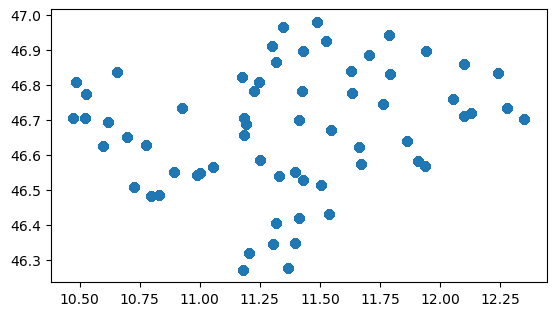

In [8]:
snow_stations.plot()

In [15]:
# load snow coverage grid
snow_grid = rio.open_rasterio("ndsi_max.tiff")
display(snow_grid.values)

array([[[0.79285175, 0.7994133 , 0.67720574, ..., 0.7761289 ,
         0.8108759 , 0.7856322 ],
        [0.83390886, 0.80718714, 0.80127716, ..., 0.79293495,
         0.82258064, 0.816163  ],
        [0.59643674, 0.6184211 , 0.6578765 , ..., 0.79516613,
         0.81645715, 0.803979  ],
        ...,
        [0.9234389 , 0.90247583, 0.902082  , ..., 0.7529947 ,
         0.79373753, 0.79000354],
        [0.92231256, 0.9010078 , 0.9001929 , ..., 0.77136844,
         0.81366557, 0.8009042 ],
        [0.91590047, 0.9083644 , 0.9098887 , ..., 0.796982  ,
         0.8237064 , 0.80756915]]], dtype=float32)

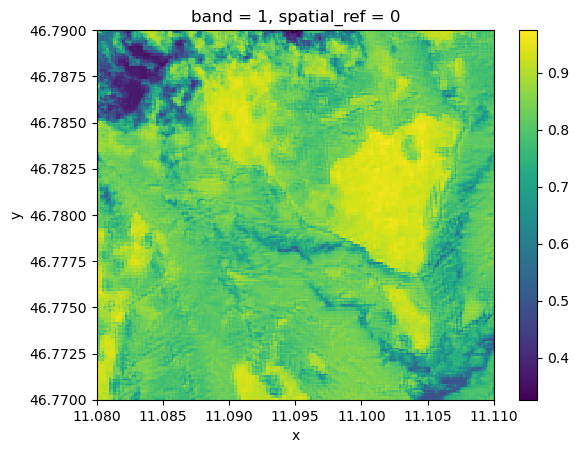

In [14]:
snow_grid.plot()

<Axes: >

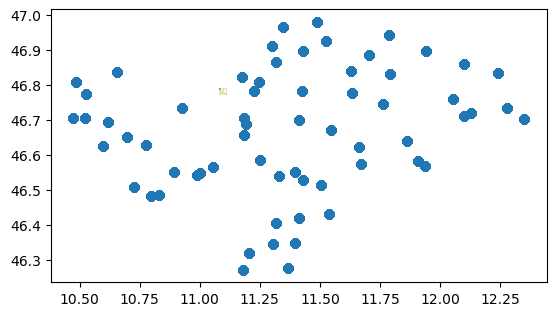

In [13]:
# display points and grid simultaneously
snow_grid_tif = rasterio.open("ndsi_max.tiff")
fig, ax = plt.subplots()
# transform rasterio plot to real world coords
extent = [snow_grid_tif.bounds[0], snow_grid_tif.bounds[2], snow_grid_tif.bounds[1], snow_grid_tif.bounds[3]]
ax = rasterio.plot.show(snow_grid_tif, ax=ax, cmap="pink")
snow_stations.plot(ax=ax)

In [79]:
# extract values from points
snow_grid_tif = rasterio.open("ndsi_max.tiff")
coord_list = [(x, y) for x, y in zip(merged_df["Longitude"], merged_df["Latitude"])]
merged_df["value"] = [x for x in snow_grid_tif.sample(coord_list)]
merged_df.sample(10)

,Provider_x,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Provider_y,Longitude,Latitude,Elevation,HN_year_start,HN_year_end,HS_year_start,HS_year_end,value
540238,IT_BZ,S_Cassiano_Osservatore,2003-02-08,NaN,NaN,NaN,NaN,31.0,IT_BZ,11.936462,46.568713,1545.0,NaN,NaN,1980.0,2019.0,[0.0]
61575,IT_BZ,Casere_di_Fuori_Osservatore,1994-08-01,NaN,NaN,NaN,NaN,0.0,IT_BZ,10.926697,46.735100,1705.0,1983.0,2018.0,1983.0,2018.0,[0.0]
194287,IT_BZ,Fleres_Osservatore,1993-12-06,NaN,NaN,NaN,NaN,NaN,IT_BZ,11.347034,46.965212,1245.0,1984.0,2012.0,1984.0,2012.0,[0.0]
767152,IT_BZ,Valluzza_Osservatore,2017-05-14,NaN,0.0,NaN,0.0,0.0,IT_BZ,11.662810,46.623574,1350.0,NaN,NaN,1980.0,2019.0,[0.0]
501457,IT_BZ,Ridanna_Osservatore,1986-12-05,0.0,19.0,0.0,19.0,19.0,IT_BZ,11.299491,46.910741,1350.0,1980.0,2013.0,1980.0,2013.0,[0.0]
323071,IT_BZ,Maia_Alta_Osservatore,2008-07-10,0.0,0.0,0.0,0.0,0.0,IT_BZ,11.183234,46.657820,334.0,1985.0,2019.0,1985.0,2019.0,[0.0]
553437,IT_BZ,S_Genesio_Atesino_Osservatore,2003-03-30,0.0,NaN,0.0,NaN,NaN,IT_BZ,11.329485,46.539106,1140.0,1984.0,2019.0,1984.0,2019.0,[0.0]
304355,IT_BZ,Luson_Osservatore,1992-04-12,0.0,0.0,0.0,0.0,0.0,IT_BZ,11.763891,46.745031,981.0,1980.0,2019.0,1980.0,2019.0,[0.0]
155189,IT_BZ,Diga_di_Zoccolo_Osservatore,1991-11-20,3.0,14.0,3.0,14.0,14.0,IT_BZ,10.988362,46.541867,1144.0,1980.0,2019.0,1980.0,2019.0,[0.0]
97006,IT_BZ,Diga_di_Gioveretto_Osservatore,2003-08-04,0.0,0.0,0.0,0.0,0.0,IT_BZ,10.725072,46.509063,1851.0,1980.0,2019.0,1980.0,2019.0,[0.0]


In [2]:
# set threshold for snow values
# Reference: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndsi/#:~:text=The%20Sentinel%2D2%20normalized%20difference,above%200.42%20are%20usually%20snow.
# values above 0.42 are snow

# snow_grid.values
# np.unique(np.where(snow_grid.values > 0.42, 1, 0), return_counts=True) # i.e. 0 represent not snow and 1 represents snow. 

In [1]:
# select ROI
# 'https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/exercises/data/catchment_outline.geojson'
# catchment_outline = gpd.read_file('data/catchment_outline.geojson')
# m = folium.Map(location=[catchment_outline.centroid.y, catchment_outline.centroid.x])
# folium.GeoJson(data=catchment_outline.to_json(), name='catchment').add_to(m)
# m

In [ ]:
# data validation
